# Gaussian processes with outliers

Suppose there are data distributed according to $Y \sim \mathcal{N}[Y \mid 0, K + \Sigma]$, but with outliers at places.
Doing inference with outliers renders the inference useless, and is indeed where point-wise marginal likelihood maximisation falls flat on its face.
With JAXNS we can marginalise over hyper parameters as easily as defining them as prior RVs and marginalising over the posterior.

Let's suppose a Gaussian process formulation of an index set $X \in \mathbb{R}^n$ and a covariance function, $K : X \times X \to \mathbb{R}$, and a mean function $\mu : X \to \mathbb{R}$.
Given the above data we see that it is equivalent to a Gaussian likelihood, with Gaussian process prior,

$L(x) = p(y | x) = \mathcal{N}[y \mid x, \Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu(X), K(X,X)]$

where $\mu(X)$ and $K(X,X)$ are the mean and covariance functions evaluated over the index set.

The evidence of this model is well known,

$Z \triangleq p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x = \mathcal{N}[y \mid \mu(X), K(X,X) + \Sigma)$

and likewise the posterior distribution is,

$p(x \mid y) = \mathcal{N}[x \mid \mu', K']$

where

$\mu' = \mu(X) + K(X,X) (K(X,X) + \Sigma)^{-1}(y - \mu(X))$

and

$K' = K(X,X) - K(X,X) (K(X,X) + \Sigma)^{-1} K(X,X)$

## Marginalisation

The mean and covariance functions are not _a priori_ known and thus we must infer them as well.
Let the hyper parameters of the mean and covariance functions, and the noise covariance be $\theta$, and suppose we wish to infer their values.
The likelihood then becomes,

$p(y \mid \theta) = \int_\mathcal{X} L(x | \theta) p(x) p(\theta) \,\mathrm{d} x = \mathcal{N}[y \mid \mu_\theta(X), K_\theta(X,X) + \Sigma_\theta)$

where we recognise this as the marginal likelihood.

Now suppose we wish to predict $x$ at new points $X' \in \mathbb{R}^n$, then this equivalent to sampling from the marginalised predictive posterior,

$$p(x(X') | y) = \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) p(y \mid \theta) p(\theta) \mathrm{d} \theta \mathrm{d} x(X)\\
= \mathbb{E}_{\theta \mid y}[p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X)]$$

Now since $p(x(X') \mid x(X))$ and $p(x(X) \mid y, \theta)$ are both Gaussians, their product is also a Gaussian, and is given by,

$$p(x(X') \mid x(X)) p(x(X) \mid y, \theta) = \mathcal{N}[x(X') \mid K(X',X)K(X,X)^{-1} x(X), K(X',X') - K(X',X)K(X,X)^{-1}K(X,X')] \mathcal{N}[x(X) \mid \mu', K']\\
\implies \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X) = \mathcal{N}[x(X') \mid m, S]$$

where

$m = K(X',X)K(X,X)^{-1} \mu'$

and

$S = K(X',X')  + K(X',X) (K(X,X)^{-1} K' K(X,X)^{-1} -  K(X,X)^{-1})K(X,X')$

Therefore, marginalising is equivalent to sampling $\theta \sim p(\theta \mid y)$, and then sampling $x(X') \sim \mathcal{N}[x(X') \mid m, S]$.

## Overview

We'll cover the following topics:

1. How to formulate a Gaussian process prior.
2. How to compute samples from the marginalised distribution
3. How to compute the marginalised mean and variance of the distribution

In [1]:
from jaxns import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior, GaussianProcessKernelPrior
from jaxns.plotting import plot_cornerplot, plot_diagnostics
from jaxns.modules.gaussian_process.kernels import RBF, M12, M32
from jaxns.utils import marginalise_dynamic, summary
from jax.scipy.linalg import solve_triangular
from jax import random, jit
from jax import numpy as jnp
import pylab as plt

# for Gaussian processes this is important
from jax.config import config
config.update("jax_enable_x64", True)

INFO[2022-03-03 18:14:18,739]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-03 18:14:18,740]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-03-03 18:14:18,741]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-03 18:14:18,742]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[ 0.48043513  1.06073094  1.6569895   1.9489872   1.69280108  0.9527187
  0.05091786 -0.60053606 -0.72316317 -0.45326501 -0.24599112 -0.34818202
 -0.5598109  -0.52166531 -0.05462039  0.73176864  1.53638301  2.02323308
  1.93803875  1.23793943  0.13700287 -1.04992252 -2.03970762 -2.56241246
 -2.43509719 -1.75943818 -0.90340669 -0.2180055   0.10626039 -0.02756169
 -0.55613597 -1.16509206 -1.51232246 -1.53679923 -1.46802779 -1.54931636
 -1.74103021 -1.75962571 -1.48199452 -1.15838319 -1.08359094 -1.19125052
 -1.14735855 -0.80051549 -0.40352245 -0.32540174 -0.54737441 -0.58155978
 -0.02131308  0.9763157 ]


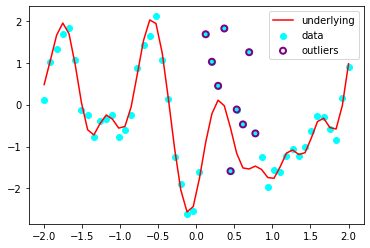

In [2]:
N = 50
X = jnp.linspace(-2., 2., N)[:, None]
true_sigma, true_l, true_uncert = 1., 0.2, 0.2
data_mu = jnp.zeros((N,))
prior_cov = RBF()(X, X, true_l, true_sigma) + 1e-13 * jnp.eye(N)

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,)) + data_mu
Y_obs = Y + true_uncert * random.normal(random.PRNGKey(1), shape=(N,))
outliers_mask = (jnp.arange(N) > 25) & (jnp.arange(N) < 35)
Y_obs = jnp.where(outliers_mask,
                  random.normal(random.PRNGKey(1), shape=(N,)),
                  Y_obs)
print(Y)
plt.plot(X[:,0], Y, c='red', label='underlying')
plt.scatter(X[:,0], Y_obs, c='cyan', label='data')
plt.scatter(X[outliers_mask,0], Y_obs[outliers_mask], label='outliers',facecolors='none',edgecolors='purple', lw=2)
plt.legend()
plt.show()


In [3]:


def run_for_kernel(kernel):
    print(("Working on Kernel: {}".format(kernel.__class__.__name__)))

    def log_normal(x, mean, cov):
        L = jnp.linalg.cholesky(cov)
        # U, S, Vh = jnp.linalg.svd(cov)
        log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
        dx = x - mean
        dx = solve_triangular(L, dx, lower=True)
        # U S Vh V 1/S Uh
        # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
        maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
        log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) \
                         - log_det \
                         - 0.5 * maha
        return log_likelihood



    def log_likelihood(K, uncert):
        """
        P(Y|sigma, half_width) = N[Y, f, K]
        Args:
            sigma:
            l:

        Returns:

        """
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return log_normal(Y_obs, mu, K + data_cov)

    def predict_f(uncert, l, sigma):
        K = kernel(X, X, l, sigma)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return mu + K @ jnp.linalg.solve(K + data_cov, Y_obs)

    def predict_fvar(uncert, l, sigma):
        K = kernel(X, X, l, sigma)
        data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
        mu = jnp.zeros_like(Y_obs)
        return jnp.diag(K - K @ jnp.linalg.solve(K + data_cov, K))

    with PriorChain() as prior_chain:
        l = UniformPrior('l', 0., 2.)
        uncert = UniformPrior('uncert', 0., 2.)
        sigma = UniformPrior('sigma', 0., 2.)
        cov = GaussianProcessKernelPrior('K', kernel, X, l, sigma, tracked=False) # we don't want to collect samples of covariance (that would be very large in memory)

    ns = NestedSampler(log_likelihood, prior_chain)

    results = jit(ns)(key=random.PRNGKey(42))

    summary(results)
    plot_diagnostics(results)
    plot_cornerplot(results)

    predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples,results.log_dp_mean,
                                                  results.ESS, predict_f)

    predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                    results.ESS, predict_fvar)

    plt.scatter(X[:, 0], Y_obs, label='data')
    plt.plot(X[:, 0], Y, label='underlying')
    plt.plot(X[:, 0], predict_f, label='marginalised')
    plt.plot(X[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
             c='black')
    plt.plot(X[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
             c='black')
    plt.title("Kernel: {}".format(kernel.__class__.__name__))
    plt.legend()
    plt.show()

    return results.log_Z_mean, results.log_Z_uncert

Working on Kernel: RBF
--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 98511
# samples: 1950
# likelihood evals / sample: 50.5
--------
logZ=-71.26 +- 0.19
H=410.0
ESS=366
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2022-03-03 18:14:38,420]: No handles with labels found to put in legend.


l: 0.176 +- 0.032 | 0.135 / 0.176 / 0.214 | 0.135 | 0.17
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.23 +- 0.25 | 0.94 / 1.18 / 1.6 | 1.19 | 1.15
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.591 +- 0.082 | 0.496 / 0.586 / 0.697 | 0.489 | 0.552
--------


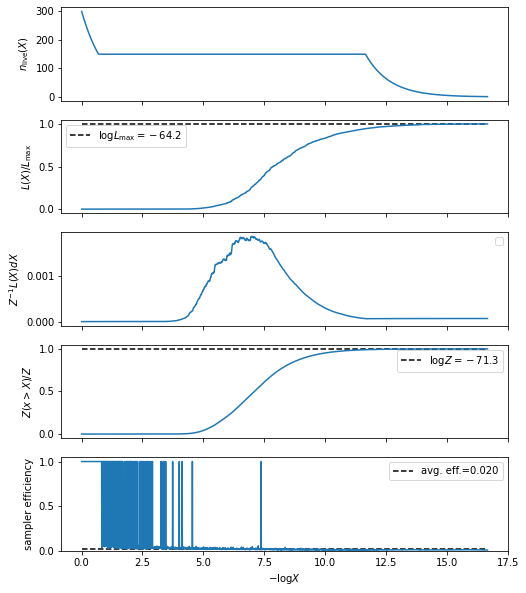

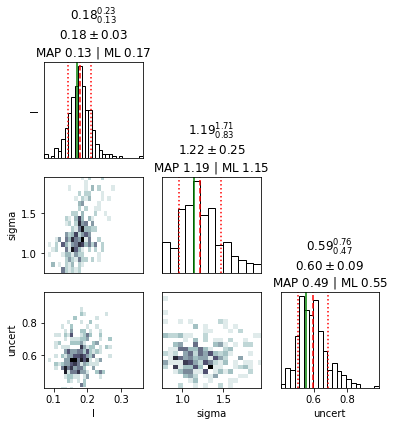

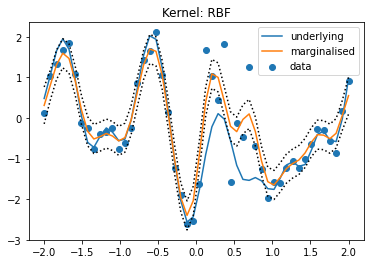

Working on Kernel: M12
--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 62623
# samples: 1669
# likelihood evals / sample: 37.5
--------
logZ=-71.55 +- 0.15
H=59.0
ESS=379
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2022-03-03 18:14:57,770]: No handles with labels found to put in legend.


l: 0.4 +- 0.22 | 0.19 / 0.34 / 0.66 | 0.56 | 0.2
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.42 +- 0.27 | 1.12 / 1.37 / 1.82 | 1.91 | 1.22
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.28 +- 0.18 | 0.06 / 0.27 / 0.52 | 0.25 | 0.0
--------


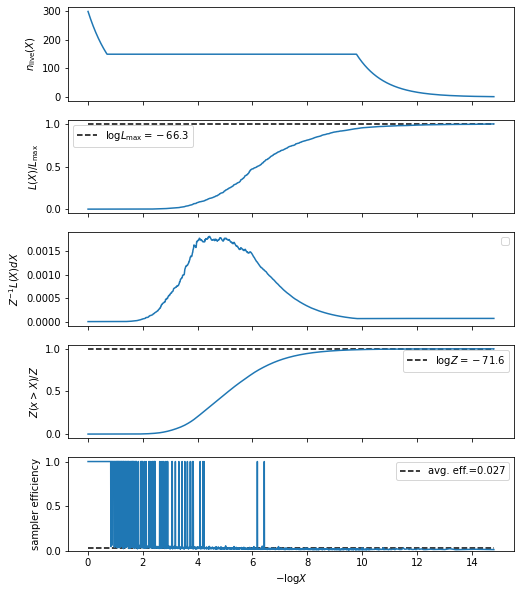

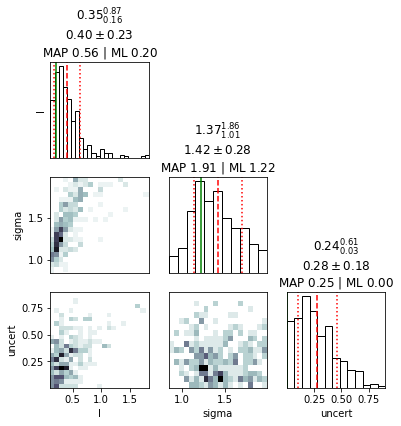

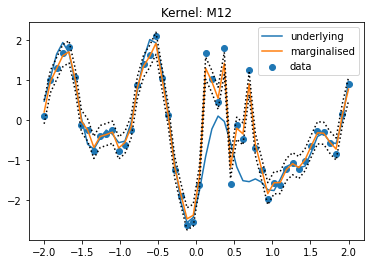

Working on Kernel: M32
--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 83459
# samples: 1832
# likelihood evals / sample: 45.6
--------
logZ=-71.74 +- 0.17
H=170.0
ESS=358
--------
l: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2022-03-03 18:15:21,204]: No handles with labels found to put in legend.


l: 0.225 +- 0.081 | 0.13 / 0.216 / 0.318 | 0.178 | 0.196
--------
sigma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sigma: 1.26 +- 0.25 | 0.97 / 1.23 / 1.63 | 1.5 | 1.14
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.52 +- 0.13 | 0.35 / 0.52 / 0.69 | 0.4 | 0.5
--------


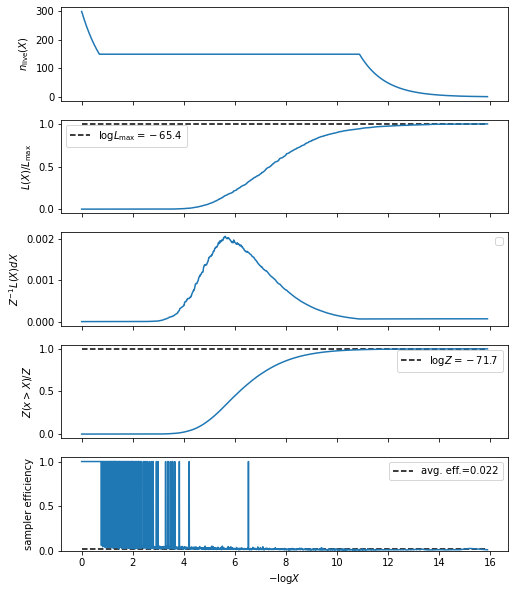

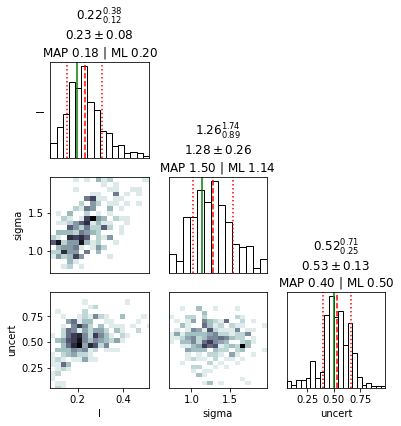

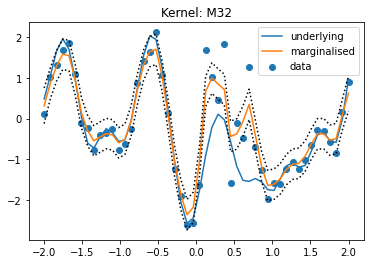

WARNING[2022-03-03 18:15:24,799]: No handles with labels found to put in legend.


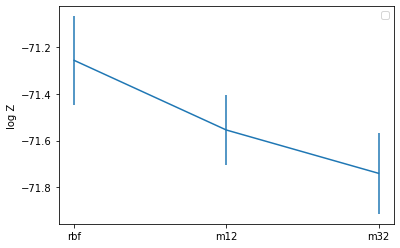

In [4]:
logZ_rbf, logZerr_rbf = run_for_kernel(RBF())
logZ_m12, logZerr_m12 = run_for_kernel(M12())
logZ_m32, logZerr_m32 = run_for_kernel(M32())

plt.errorbar(['rbf', 'm12', 'm32'], [logZ_rbf, logZ_m12, logZ_m32], [logZerr_rbf, logZerr_m12, logZerr_m32])
plt.ylabel("log Z")
plt.legend()
plt.show()